# Function Approximation Tutorial

This tutorial demonstrates how to use the `func_approx` module from evotool to solve function approximation problems using various evolutionary algorithms.

## Overview

The `func_approx` module provides:
- Data generators for common function types (polynomial, sine wave, exponential decay)
- An evaluator that scores candidate functions based on their approximation quality
- Adapters for different evolutionary algorithms (ES, FunSearch, EOH, EvoEngineer)

## Basic Usage

### 1. Generate Training Data

First, let's generate some noisy data to approximate:

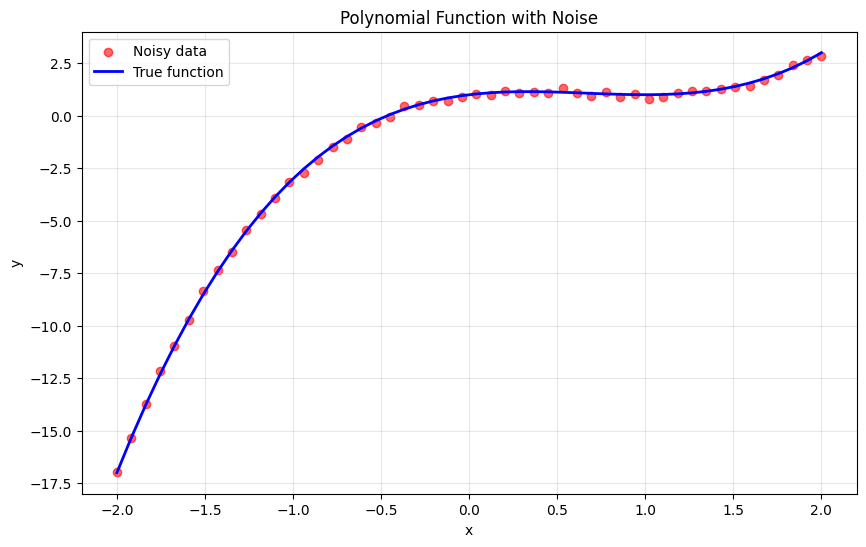

Generated 50 data points
X range: [-2.00, 2.00]
Y range: [-16.95, 2.82]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from evotool.task.python_task.func_approx import generate_noisy_polynomial, generate_sine_wave

# Generate polynomial data: y = x³ - 2x² + x + 1 + noise
x_data, y_noisy, y_true = generate_noisy_polynomial(n_points=50, noise_level=0.1, seed=42)

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_noisy, alpha=0.6, label='Noisy data', color='red')
plt.plot(x_data, y_true, 'b-', label='True function', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Polynomial Function with Noise')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Generated {len(x_data)} data points")
print(f"X range: [{x_data.min():.2f}, {x_data.max():.2f}]")
print(f"Y range: [{y_noisy.min():.2f}, {y_noisy.max():.2f}]")

### Alternative: Generate sine wave data

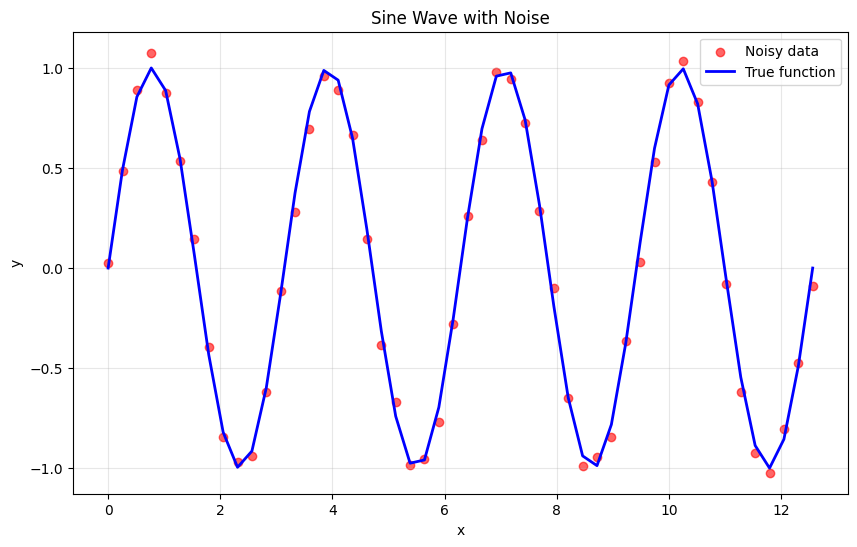

In [2]:
# Generate sine wave data
x_sine, y_sine_noisy, y_sine_true = generate_sine_wave(n_points=50, freq=2.0, noise_level=0.05, seed=42)

plt.figure(figsize=(10, 6))
plt.scatter(x_sine, y_sine_noisy, alpha=0.6, label='Noisy data', color='red')
plt.plot(x_sine, y_sine_true, 'b-', label='True function', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sine Wave with Noise')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 2. Set Up the Evaluator

The evaluator expects your code to define an `approximate` function:

In [3]:
from evotool.task.python_task.func_approx import FuncApproxEvaluator

evaluator = FuncApproxEvaluator(x_data, y_noisy, y_true, timeout_seconds=30.0)
print("Evaluator created successfully!")

Evaluator created successfully!


### 3. Define and Test a Candidate Solution

Your function must be named `approximate` and take the x data as input:

In [4]:
# Perfect solution (we know the true function)
candidate_code = """
def approximate(x):
    # Simple polynomial approximation
    return x**3 - 2*x**2 + x + 1
"""

# Test the candidate
result = evaluator.evaluate_code(candidate_code)
print(f"Valid: {result.valid}")
print(f"Score (R²): {result.score:.4f}")
print(f"MSE: {result.additional_info['mse']:.4f}")
print(f"True R²: {result.additional_info.get('true_r2', 'N/A'):.4f}")

Valid: True
Score (R²): 0.9996
MSE: 0.0091
True R²: 1.0000


Let's visualize the approximation:

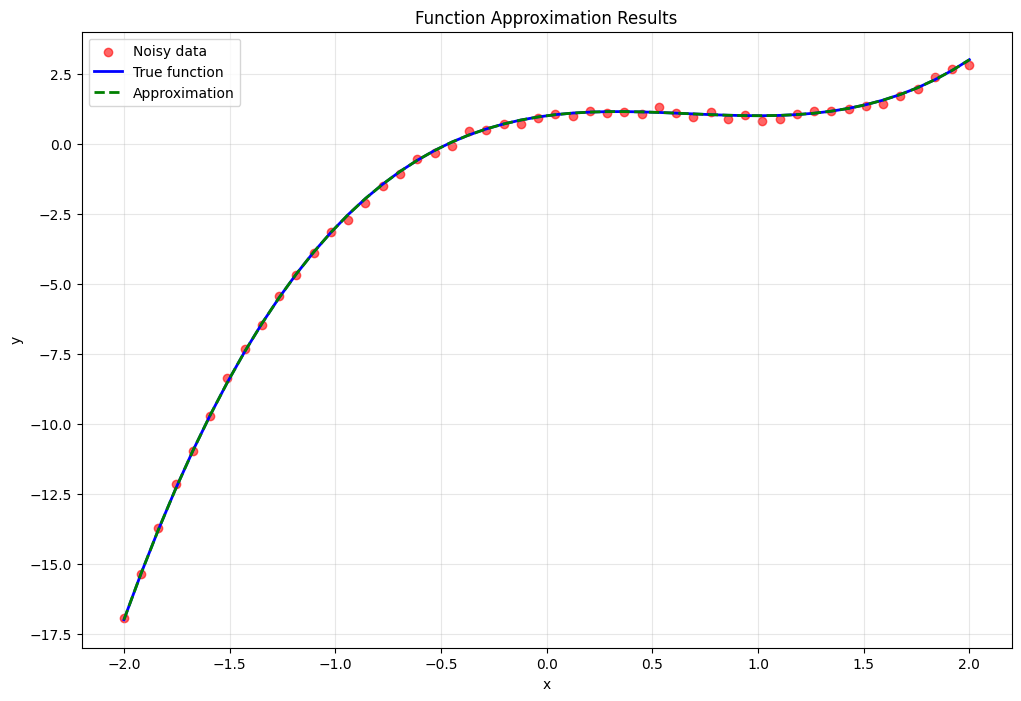

Mean Squared Error: 0.0091
Mean Absolute Error: 0.0766


In [5]:
# Test the approximate function
def approximate(x):
    return x**3 - 2*x**2 + x + 1

y_pred = approximate(x_data)

plt.figure(figsize=(12, 8))
plt.scatter(x_data, y_noisy, alpha=0.6, label='Noisy data', color='red')
plt.plot(x_data, y_true, 'b-', label='True function', linewidth=2)
plt.plot(x_data, y_pred, 'g--', label='Approximation', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Function Approximation Results')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate and display errors
mse = np.mean((y_pred - y_noisy) ** 2)
mae = np.mean(np.abs(y_pred - y_noisy))
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

## Complete Example with Evolution Strategy

Here's a complete example using the ES (1+1) adapter:

In [2]:
import os
from evotool.task.python_task.func_approx import (
    generate_noisy_polynomial,
    FuncApproxEvaluator,
    Es1p1FuncApproxAdapter
)
from evotool.evo_method.es_1p1 import Es1p1, Es1p1Config
from evotool.tools import HttpsApi

# 1. Generate training data
x_data, y_noisy, y_true = generate_noisy_polynomial(n_points=50, noise_level=0.15, seed=123)

# 2. Create evaluator
evaluator = FuncApproxEvaluator(x_data, y_noisy, y_true)

# 3. Initial candidate (simple linear function)
initial_code = '''
def approximate(x):
    # Linear approximation: y = ax + b
    a = 1.0
    b = 0.0
    return a * x + b
'''

print("Initial linear approximation:")
result = evaluator.evaluate_code(initial_code)
print(f"Initial score: {result.score:.4f}")

Initial linear approximation:
Initial score: 0.2085


In [3]:
task_info = {
    'x_data': x_data.tolist(),
    'y_data': y_noisy.tolist(),
    'y_true': y_true.tolist()
}
# 4. Set up ES adapter
es_adapter = Es1p1FuncApproxAdapter(task_info)

output_path = "./es1p1_func_approx_results"
os.makedirs(output_path, exist_ok=True)
running_llm = HttpsApi(
    "ai.api.xn--fiqs8s",
    "",
    "gpt-4.1-2025-04-14",
    "/v1/chat/completions"
)
es_config = Es1p1Config(
    task_info=task_info,
    output_path=output_path,
    running_llm=running_llm,
    evaluator=evaluator,
    adapter=es_adapter
)

es = Es1p1(es_config)

# 5. Run evolution
print("Running evolution...")
es.run()

# print("\nBest solution found:")
# print(best_solution.code)
# print(f"Final score: {best_solution.fitness:.4f}")

Loading run state from file ./es1p1_func_approx_results/run_state.json
Running evolution...
                 ES(1+1) ALGORITHM STARTED                  
Samples  1 - 5 / 45 
Sampler 0: Generated a sample.
Sampler 4: Generated a sample.
Sampler 2: Generated a sample.
Sampler 1: Generated a sample.
Sampler 3: Generated a sample.
Sample evaluated - Score: 0.9991159534788517
Sample evaluated - Score: 0.9990334845437526
Sample evaluated - Score: 0.9990334879803949
Sample evaluated - Score: 0.9990334879803949
Sample evaluated - Score: 0.0
Samples  6 - 10 / 45 
Sampler 0: Generated a sample.
Sampler 3: Generated a sample.
Sampler 2: Generated a sample.
Sampler 4: Generated a sample.
Sampler 1: Generated a sample.
Sample evaluated - Score: 0.9993485660054119
Sample evaluated - Score: 0.9958037587645593
Sample evaluated - Score: 0.9991080689827931
Sample evaluated - Score: 0.9985397455066947
Sample evaluated - Score: 0.9993484052447417
Samples  11 - 15 / 45 
Sampler 3: Generated a sample.
Sampl

## Advanced Example with Custom Data

You can also create your own custom function to approximate:

In [ ]:
from evotool.task.python_task.func_approx import generate_custom_function, FuncApproxEvaluator

# Define a complex custom function
def complex_function(x):
    return np.sin(x) * np.exp(-0.1 * x) + 0.5 * x

# Generate data
x_data, y_noisy, y_true = generate_custom_function(
    func=complex_function,
    x_range=(0, 10),
    n_points=100,
    noise_level=0.1,
    seed=42
)

# Visualize the custom function
plt.figure(figsize=(12, 8))
plt.scatter(x_data, y_noisy, alpha=0.6, label='Noisy data', color='red', s=20)
plt.plot(x_data, y_true, 'b-', label='True function', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Custom Function: sin(x) * exp(-0.1*x) + 0.5*x')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Create evaluator
evaluator = FuncApproxEvaluator(x_data, y_noisy, y_true)

# Test a candidate solution
candidate_code = """
import math

def approximate(x):
    # Try to approximate: sin(x) * exp(-0.1*x) + 0.5*x
    return np.sin(x) * np.exp(-0.1 * x) + 0.5 * x
"""

result = evaluator.evaluate_code(candidate_code)
print(f"Approximation quality: R² = {result.score:.4f}")
print(f"MSE: {result.additional_info_dict['mse']:.6f}")
print(f"True R²: {result.additional_info_dict.get('true_r2', 'N/A'):.4f}")

## Function Requirements

Your `approximate` function must:

1. **Be named exactly `approximate`**
2. **Take one parameter** (the x data array)
3. **Return a numpy array** with the same shape as the input
4. **Use only allowed imports**: `numpy` (as `np`) and `math` are available
5. **Complete within the timeout** (default 30 seconds)

### Valid Function Examples:

In [ ]:
# Example 1: Polynomial approximation
poly_code = """
def approximate(x):
    return 2*x**3 - x**2 + 3*x + 1
"""

# Example 2: Trigonometric approximation  
trig_code = """
def approximate(x):
    return np.sin(2*x) + 0.5*np.cos(x)
"""

# Example 3: Exponential approximation
exp_code = """
def approximate(x):
    return 2 * np.exp(-0.5 * x)
"""

# Example 4: Piecewise approximation
piecewise_code = """
def approximate(x):
    result = np.zeros_like(x)
    mask1 = x < 0
    mask2 = x >= 0
    result[mask1] = x[mask1]**2
    result[mask2] = np.sqrt(np.abs(x[mask2]))
    return result
"""

# Test these examples
examples = [
    ("Polynomial", poly_code),
    ("Trigonometric", trig_code),
    ("Exponential", exp_code),
    ("Piecewise", piecewise_code)
]

for name, code in examples:
    result = evaluator.evaluate_code(code)
    print(f"{name}: Valid={result.valid}, Score={result.score:.4f}")

## Evaluation Metrics

The evaluator provides several metrics:

In [ ]:
# Demonstrate evaluation metrics
test_code = """
def approximate(x):
    return x**3 - 2*x**2 + x + 1
"""

result = evaluator.evaluate_code(test_code)

print("Evaluation Metrics:")
print(f"- score: {result.score:.4f} (R-squared value - higher is better)")
print(f"- mse: {result.additional_info_dict['mse']:.4f} (Mean Squared Error against noisy data)")
print(f"- mae: {result.additional_info_dict['mae']:.4f} (Mean Absolute Error against noisy data)")
print(f"- r2: {result.additional_info_dict['r2']:.4f} (R-squared against noisy data)")

if 'true_mse' in result.additional_info_dict:
    print(f"- true_mse: {result.additional_info_dict['true_mse']:.4f} (MSE against true function)")
    print(f"- true_mae: {result.additional_info_dict['true_mae']:.4f} (MAE against true function)")
    print(f"- true_r2: {result.additional_info_dict['true_r2']:.4f} (R-squared against true function)")

## Available Evolutionary Algorithms

The module includes adapters for various evolutionary algorithms:

- `Es1p1FuncApproxAdapter`: (1+1) Evolution Strategy
- `FunSearchFuncApproxAdapter`: FunSearch algorithm
- `EohFuncApproxAdapter`: Evolution of Heuristics
- `EvoEngineerFuncApproxAdapter`: EvoEngineer algorithm

Each adapter has its own parameters and can be configured based on your specific needs.

## Tips for Better Results

1. **Start simple**: Begin with basic polynomial or trigonometric functions
2. **Use domain knowledge**: If you know the function type, incorporate that into your approximation
3. **Handle edge cases**: Ensure your function works for all x values in the domain
4. **Monitor convergence**: Track the score over generations to see if evolution is progressing
5. **Experiment with noise levels**: Higher noise makes the problem more challenging but more realistic

## Summary

This tutorial demonstrated:
- How to generate training data for function approximation
- How to set up and use the FuncApproxEvaluator
- How to define valid approximation functions
- How to use evolutionary algorithms to optimize function approximations
- Understanding of evaluation metrics and requirements

You can now experiment with different function types, evolutionary algorithms, and approximation strategies!